# Descripción de la Notebook

Lee desde el archivo CSV los datos de los tracks. Aplica algunas transformaciones a los datos y luego entrena diferentes modelos.
Al final se muestran los resultados de todos los modelos, y se realiza una predicción con un set de datos de tracks correspondientes al año 2020.

<a id="titulo"></a>
- <a href="#imports"> Imports </a>
- <a href="#pickle_config"> Seteo de la variable para leer los modelos desde pickle </a>
- <a href="#csv">Se lee el CSV de tracks tranformado. </a>
- <a href="#tratamiento_datos">Transformación de datos</a>
- <a href="#vars_obj">Se definen las clases para la variable objetivo</a>
- <a href="#analisis_datos">Análisis de datos</a>
- <a href="#entrenamiento">Se realiza el entrenamiento para los diferentes modelos</a>
    - <a href="#model_logistic_regression">Logistic Regression</a>
    - <a href="#model_multinomial_naive_bayes">Multinomial Naive Bayes</a>    
    - <a href="#model_knn">KNN</a>   
    - <a href="#model_DTC">Decision Tree Classifier</a>   
    - <a href="#model_random_forest">Random Forest</a>   
    - <a href="#model_extra_tree">Extra tree Classifier</a>
    - <a href="#model_bagging_decision_tree">Bagging con Decision Tree Classifier</a>
- <a href="#feature_selection">Se hace una reducción de features</a>
    - Se vuelve a probar los modelos con features reducidas
        - <a href="#feature_selection_logistic_regression">Logistic Regression</a>
        - <a href="#feature_selection_bernoulli_naive_bayes">Mutinomial Naive Bayes</a>                    
- <a href="#results">Se presentan resultados</a>
- <a href="#test_analysis">Prediciendo en el set de test 2020</a>

# Imports <a id="imports"></a>

<a href="#titulo">Volver al índice</a>

In [166]:
import warnings
warnings.simplefilter("ignore")

In [167]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd
import datetime
import time

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV #feature selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from imblearn.over_sampling import SMOTE #pip install -U imbalanced-learn

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import pickle

# Importamos bibliotecas propias

In [168]:
import os
import sys
sys.path.append(os.path.abspath("_3_Anexo_Func2.py"))

import _3_Anexo_Func2 as funcs

# Configuracion de la lectura de los modelos desde pickle <a id="pickle_config"></a>

<a href="#titulo">Volver al índice</a>

##### Si esta variable está en False, los modelos se calculan durante la ejecución. SI en cambio está en True, lee los modelos desde los archivos .pkl

In [169]:
leer_modelos_desde_pickle = True

# Levantamos el CSV <a id="csv"></a>

<a href="#titulo">Volver al índice</a>

In [170]:
pathArchivoDataSet = 'tracks_clean.csv' 
df = pd.read_csv(pathArchivoDataSet)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29133 entries, 0 to 29132
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          29133 non-null  int64  
 1   name                29133 non-null  object 
 2   album               29133 non-null  object 
 3   duration_ms         29133 non-null  int64  
 4   explicit            29133 non-null  int64  
 5   danceability        29133 non-null  float64
 6   energy              29133 non-null  float64
 7   loudness            29133 non-null  float64
 8   mode                29133 non-null  int64  
 9   speechiness         29133 non-null  float64
 10  acousticness        29133 non-null  float64
 11  instrumentalness    29133 non-null  float64
 12  liveness            29133 non-null  float64
 13  valence             29133 non-null  float64
 14  tempo               29133 non-null  float64
 15  artista_followers   29133 non-null  int64  
 16  arti

# Tratamiento de variables <a id="tratamiento_datos"></a>

<a href="#titulo">Volver al índice</a>

##### Eliminamos repetidos por nombre de tema y nombre de artista, nos quedamos con el último

In [172]:
df = df.drop_duplicates(subset=['name','artista_name'],keep='last')

##### Codificamos la fecha de release_date a integer para poder hacer luego el balanceo de clases con SMOTE

In [173]:
df['release_date_year'] = df['release_date'].apply(lambda f: f[0:4])

In [174]:
df['release_date_year'].unique()

array(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019'], dtype=object)

#### Generación de dummies para el dato 'escala'

In [175]:
df = pd.get_dummies(df, drop_first=True, columns=['escala'])

##### Transformamos la variable duration_ms en duration, que es en minutos

In [176]:
df['duration'] = df['duration_ms'] / 1000 / 60

In [177]:
#quitamos la duracion en ms
df = df.drop(labels=['duration_ms'], axis=1)

# Definimos las clases de la variable objetivo <a id="vars_obj"></a>

<a href="#titulo">Volver al índice</a>

In [178]:
classes_labels = [0,1,2]

In [179]:
def target_classes_generator(popularityValue):
    if(popularityValue < 44):
        return 0
    if(popularityValue >= 44 and popularityValue < 70):
        return 1
    if(popularityValue >= 70):
        return 2

##### Definimos un diccionario para tener labels para el código

In [180]:
target_classes_labels = {0: 'mala', 1: 'buena', 2: 'muy_buena' }

In [181]:
df['popularity_class'] = df['popularity'].apply(lambda p: target_classes_generator(p))

# Análisis de datos <a id="analisis_datos"></a>

<a href="#titulo">Volver al índice</a>

#### Gráfico de la distribución de los valores de popularidad

cambiar el tamaño de los means

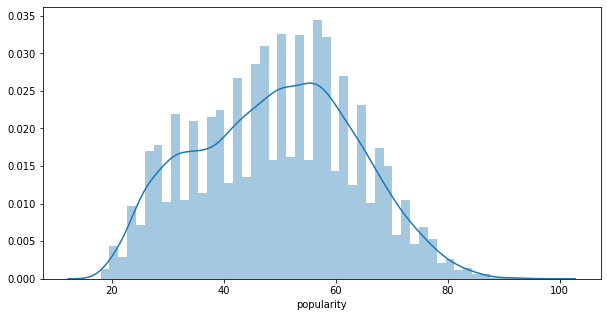

In [182]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['popularity']);

#### Gráfico que muestra las cantidades de tracks para cada una de las clases objetivo definidas

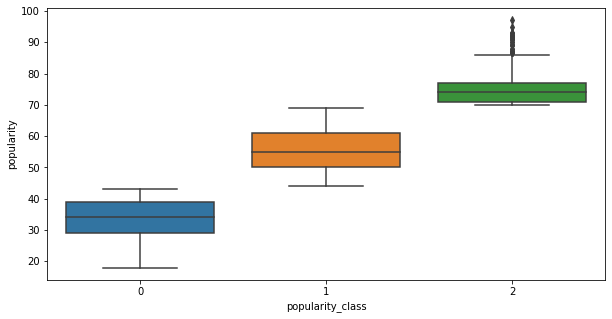

In [183]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='popularity_class', y='popularity', data=df)

# Entrenamiento de modelos <a id="entrenamiento"></a>

<a href="#titulo">Volver al índice</a>

In [184]:
#array de diccionarios donde vamos a ir almacenando los resultados para mostrarlos al final
array_resultados = []

def guardar_resultados(label, train_score, test_score):
    array_resultados.append({'modelo': label, 'train_score': train_score, 'test_score':test_score})

In [185]:
training_cols = ['duration', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'time_signature',
       'release_date_year', 'genre_ska', 'genre_flamenco', 'genre_metal',
       'genre_opera', 'genre_samba', 'genre_anime', 'genre_groove',
       'genre_indie', 'genre_bossa_nova', 'genre_trance', 'genre_rumba',
       'genre_gothic', 'genre_r&b', 'genre_under', 'genre_christian',
       'genre_folk', 'genre_reggae', 'genre_alternative', 'genre_rock',
       'genre_dubstep', 'genre_mambo', 'genre_dance', 'genre_country',
       'genre_funk', 'genre_reggaeton', 'genre_salsa', 'genre_swing',
       'genre_movie', 'genre_house', 'genre_freestyle', 'genre_instrumental',
       'genre_hip hop', 'genre_world', 'genre_blues', 'genre_neo',
       'genre_merengue', 'genre_disco', 'genre_punk', 'genre_bolero',
       'genre_jazz', 'genre_hardcore', 'genre_electronic', 'genre_trap',
       'genre_cumbia', 'genre_dub', 'genre_pop', 'genre_rave', 'genre_techno',
       'genre_ambient', 'genre_melodic', 'genre_progressive',
       'genre_experimental', 'genre_rap', 'genre_soul', 'genre_deep',
       'genre_tango', 'genre_others','escala_Do#', 'escala_Fa', 'escala_Fa#',
       'escala_La', 'escala_La#', 'escala_Mi', 'escala_Re', 'escala_Re#',
       'escala_Si', 'escala_Sol', 'escala_Sol#']

In [186]:
target_col = 'popularity_class'

In [187]:
X = df[training_cols]
y = df[target_col]

##### Vemos que las clases están desbalanceadas

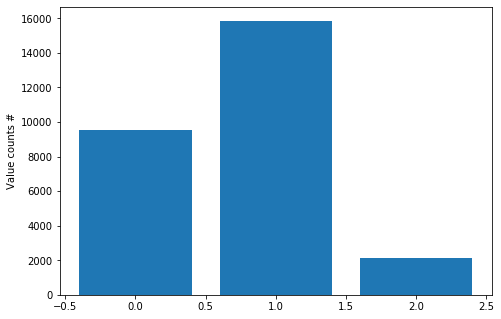

In [188]:
classes_status = pd.Series(y).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Ya que la clase intermedia está sobre representada, eliminamos algunos registros para balancear un poco y que el entrenamiento de los modelos no consuma muchos recursos

In [189]:
percent_to_delete = .4
df_simplified = df.drop(df[df['popularity_class'] == 1].sample(frac=percent_to_delete).index)

In [190]:
X_simplified = df_simplified[training_cols]
y_simplified = df_simplified[target_col]

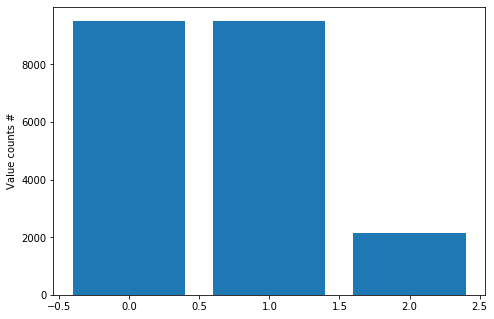

In [191]:
classes_status = pd.Series(y_simplified).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Oversampleamos las clases con menos ocurrencias con smote para balancear los datos

In [192]:
X_simplified_smoted, y_simplified_smoted  = SMOTE().fit_resample(X_simplified, y_simplified)

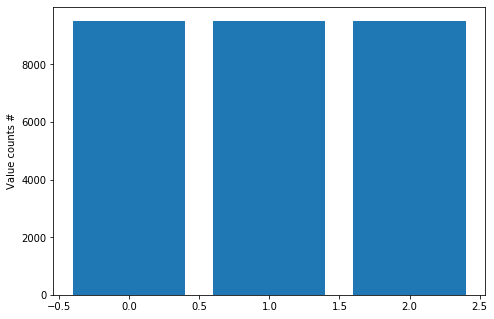

In [193]:
classes_status = pd.Series(y_simplified_smoted).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Train, test, split para el entrenamiento de modelos

In [194]:
X_train_simplified_smoted, X_test_simplified_smoted, y_train_simplified_smoted, y_test_simplified_smoted = train_test_split(X_simplified_smoted, y_simplified_smoted, test_size=0.3, random_state=42)

## Logistic Regression  <a id="model_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

In [195]:
reg_log_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', linear_model.LogisticRegression())]

reg_log_pipe_grid=Pipeline(reg_log_pasos)

##### Definimos hiperparámetros para el modelo

In [196]:
reg_log_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                           'clasificador__random_state':[42], 
                           'clasificador__C':np.linspace(0.0001, 5, 5), 
                           'clasificador__penalty':['l2', 'elasticnet'],
                           'clasificador__multi_class':['multinomial'],
                          'clasificador__class_weight':['balanced'],
                          'clasificador__solver': ['newton-cg', 'sag', 'saga','lbfgs']}]

In [197]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
    reg_log_grid=GridSearchCV(reg_log_pipe_grid, reg_log_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    reg_log_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [198]:
if(not leer_modelos_desde_pickle):
    pickle.dump(reg_log_grid, open('reg_log_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [199]:
if(leer_modelos_desde_pickle):
    reg_log_grid = pickle.load(open('reg_log_grid.pkl', 'rb'))

##### Vemos los resultados

In [200]:
reg_log_grid.best_params_

{'clasificador__C': 3.7500250000000004,
 'clasificador__class_weight': 'balanced',
 'clasificador__multi_class': 'multinomial',
 'clasificador__penalty': 'l2',
 'clasificador__random_state': 42,
 'clasificador__solver': 'lbfgs',
 'preprocesamiento': MinMaxScaler()}

##### Resultados sobre el df reducido y smoteado

In [201]:
reg_log_score_training = reg_log_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('Regresión Logística train score: ' + str(reg_log_score_training))

Regresión Logística train score: 0.7451235370611183


In [202]:
reg_log_score_test = reg_log_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Regresión Logística test score: ' + str(reg_log_score_test))

Regresión Logística test score: 0.7370755047263391


In [203]:
guardar_resultados('Logistic Regression', reg_log_score_training, reg_log_score_test)

##### Predictions

In [204]:
reg_log_predicciones = reg_log_grid.predict(X_test_simplified_smoted)

array([2109,  558,  147,  636, 1807,  430,   65,  417, 2400], dtype=int64)

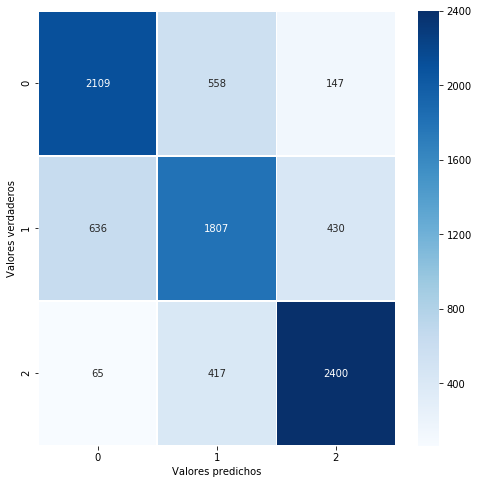

In [205]:
funcs.getConfusionMatrix(y_test_simplified_smoted, reg_log_predicciones, size = 8, labels= classes_labels)

##### Aporte de cada uno de los coeficientes

In [206]:
lr_coeficientes = reg_log_grid.best_estimator_.steps[1][1].coef_

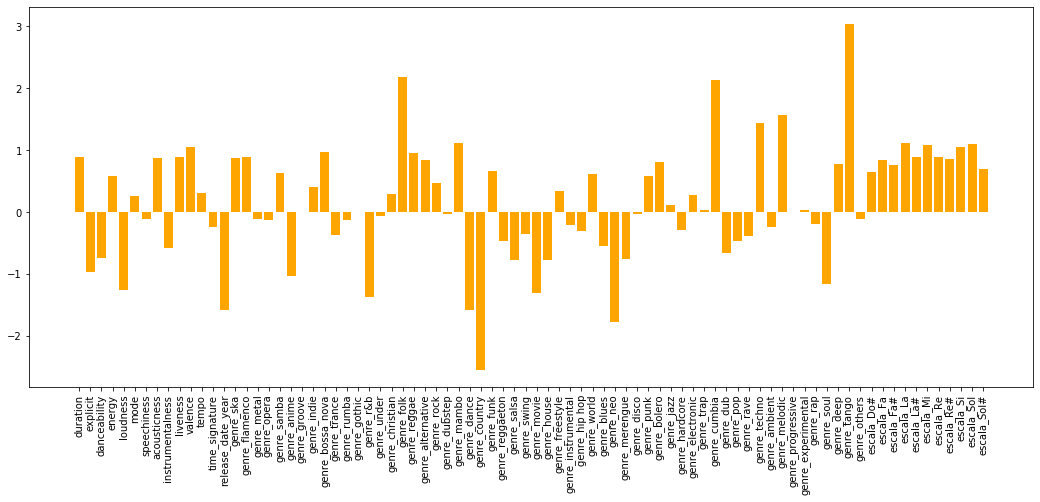

In [207]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_train_simplified_smoted.columns, rotation=90)
plt.show()

## Multinomial Naive Bayes  <a id="model_multinomial_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

In [208]:
bnb_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', MultinomialNB())]

bnb_pipe_grid=Pipeline(bnb_pasos)

##### Definimos hiperparámetros para el modelo

In [209]:
bnb_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                        'clasificador__alpha':np.linspace(0.0001, 10, 20)}]

In [210]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    mnb_grid=GridSearchCV(bnb_pipe_grid, bnb_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    mnb_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [211]:
if(not leer_modelos_desde_pickle):
    pickle.dump(mnb_grid, open('mnb_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [212]:
if(leer_modelos_desde_pickle):
    bnb_grid = pickle.load(open('mnb_grid.pkl', 'rb'))

##### Vemos los resultados

In [213]:
bnb_grid.best_params_

{'clasificador__alpha': 0.0001, 'preprocesamiento': MinMaxScaler()}

In [214]:
bnb_score_training = bnb_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('Multinomial Naive Bayes training score: ' + str(bnb_score_training))

Multinomial Naive Bayes training score: 0.696408922676803


In [215]:
bnb_score_test = bnb_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Multinomial Naive Bayes test score: ' + str(bnb_score_test))

Multinomial Naive Bayes test score: 0.6914459096744078


In [216]:
guardar_resultados('Multinomial Naive Bayes', bnb_score_training, bnb_score_test)

##### Predictions

In [217]:
bnb_predicciones = bnb_grid.predict(X_test_simplified_smoted)

array([2091,  427,  296,  718, 1384,  771,  135,  297, 2450], dtype=int64)

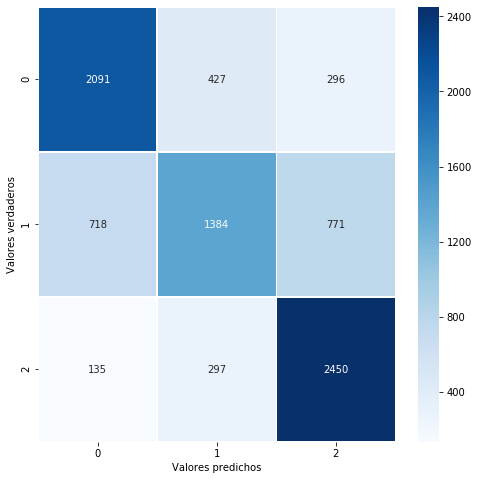

In [218]:
funcs.getConfusionMatrix(y_test_simplified_smoted, bnb_predicciones, size = 8, labels= classes_labels)

## KNN  <a id="model_knn"></a>

<a href="#titulo">Volver al índice</a>

In [219]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
knn_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', KNeighborsClassifier(n_neighbors=2))]

knn_pipe_grid=Pipeline(knn_pasos)

##### Definimos los parametros para el gridsearch cv

In [220]:
knn_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                       'clasificador__n_neighbors':range(1,4,1), 
                       'clasificador__algorithm':['ball_tree','kd_tree'],
                       'clasificador__leaf_size':[range(10, 60, 5)],#este hiperparametro solo funciona cuando se usa ball_tree o kd_tree
                       'clasificador__weights':['uniform','distance']},
                     {'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                       'clasificador__n_neighbors':range(1,4,1), 
                       'clasificador__algorithm':['brute'],
                       'clasificador__weights':['uniform','distance']}]

In [221]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    knn_grid=GridSearchCV(knn_pipe_grid, knn_new_param_grid, cv=kf, verbose=2)
    knn_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [222]:
if(not leer_modelos_desde_pickle):
    pickle.dump(knn_grid, open('knn_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [223]:
if(leer_modelos_desde_pickle):
    knn_grid = pickle.load(open('knn_grid.pkl', 'rb'))

##### Vemos los mejores parametros resultantes

In [224]:
knn_grid.best_params_

{'clasificador__algorithm': 'brute',
 'clasificador__n_neighbors': 3,
 'clasificador__weights': 'distance',
 'preprocesamiento': StandardScaler()}

In [225]:
knn_score_training = knn_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('KNN training score: ' + str(knn_score_training))

KNN training score: 0.8758627588276483


In [226]:
knn_score_test = knn_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('KNN test score: ' + str(knn_score_test))

KNN test score: 0.8750145874664488


In [227]:
guardar_resultados('KNN', knn_score_training, knn_score_test)

##### Predictions

In [228]:
knn_y_pred = knn_grid.predict(X_test_simplified_smoted)

##### Analizamos los resultados en la matriz de confusión

array([2600,  167,   47,  378, 2166,  329,   28,  122, 2732], dtype=int64)

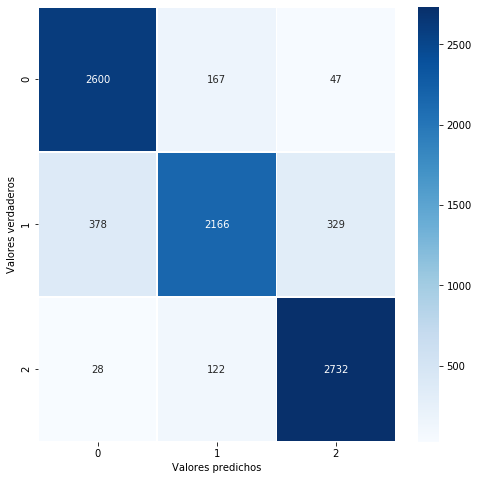

In [229]:
funcs.getConfusionMatrix(y_test_simplified_smoted, knn_y_pred, size= 8, labels= classes_labels)

## Decision Tree Classifier  <a id="model_DTC"></a>

<a href="#titulo">Volver al índice</a>

In [230]:
tree_overfit = DecisionTreeClassifier(random_state=42)
tree_overfit.fit(X_train_simplified_smoted, y_train_simplified_smoted)

DecisionTreeClassifier(random_state=42)

In [231]:
print('Sin restringir el árbol podemos ver que overfitea:')
print('Classifier tree training score: ' + str(tree_overfit.score(X_train_simplified_smoted, y_train_simplified_smoted)))
print('Classifier tree test score: ' + str(tree_overfit.score(X_test_simplified_smoted, y_test_simplified_smoted)))

Sin restringir el árbol podemos ver que overfitea:
Classifier tree training score: 0.9998999699909973
Classifier tree test score: 0.6880616174582799


##### Creamos el pipe

In [232]:
dtc_log_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', DecisionTreeClassifier(random_state=42))]

dtc_pipe_grid=Pipeline(dtc_log_pasos)

##### Definimos hiperparámetros para el modelo

In [233]:
dtc_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                       'clasificador__random_state':[42], 
                       'clasificador__max_depth':[3,6,9], 
                       'clasificador__max_features':[70,75,82],
                       'clasificador__max_leaf_nodes':[10,15,20],
                       'clasificador__min_samples_leaf':range(1, 4),
                      'clasificador__min_samples_split': [9, 12, 15]
                      }]

In [234]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    dtc_log_grid=GridSearchCV(dtc_pipe_grid, dtc_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    dtc_log_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [235]:
if(not leer_modelos_desde_pickle):
    pickle.dump(dtc_log_grid, open('dtc_log_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [236]:
if(leer_modelos_desde_pickle):
    dtc_log_grid = pickle.load(open('dtc_log_grid.pkl', 'rb'))

In [237]:
print('Mejor estimador GridCV: ' + str(dtc_log_grid.best_estimator_))
print('Mejor score GridCV: ' + str(dtc_log_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                ('clasificador',
                 DecisionTreeClassifier(max_depth=9, max_features=82,
                                        max_leaf_nodes=20, min_samples_split=9,
                                        random_state=42))])
Mejor score GridCV: 0.6806043797864231


In [238]:
dtc_log_grid.best_params_

{'clasificador__max_depth': 9,
 'clasificador__max_features': 82,
 'clasificador__max_leaf_nodes': 20,
 'clasificador__min_samples_leaf': 1,
 'clasificador__min_samples_split': 9,
 'clasificador__random_state': 42,
 'preprocesamiento': MinMaxScaler()}

In [239]:
#aplicamos el scaler sobre los datos de train y test
X_train_simplified_smoted_scaled = dtc_log_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = dtc_log_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

#instanciamos nuevamente un decision tree classifier con los mejores parámetros obtenidos
tree = DecisionTreeClassifier(random_state= dtc_log_grid.best_params_['clasificador__random_state'],
                             max_depth=dtc_log_grid.best_params_['clasificador__max_depth'],
                             max_leaf_nodes= dtc_log_grid.best_params_['clasificador__max_leaf_nodes'],
                             min_samples_leaf= dtc_log_grid.best_params_['clasificador__min_samples_leaf'],
                             min_samples_split= dtc_log_grid.best_params_['clasificador__min_samples_split'],
                             max_features=dtc_log_grid.best_params_['clasificador__max_features'])
#fiteamos
tree.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)

DecisionTreeClassifier(max_depth=9, max_features=82, max_leaf_nodes=20,
                       min_samples_split=9, random_state=42)

In [240]:
classifier_tree_score_training = tree.score(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
print('Classifier tree training score: ' + str(classifier_tree_score_training))

Classifier tree training score: 0.6801040312093628


In [241]:
classifier_tree_score_test = tree.score(X_test_simplified_smoted_scaled, y_test_simplified_smoted)
print('Classifier tree training score: ' + str(classifier_tree_score_test))

Classifier tree training score: 0.6704399579880966


In [242]:
guardar_resultados('Decision Tree Classifier', classifier_tree_score_training, classifier_tree_score_test)

In [243]:
# Calcular la importancia de los atributos
tree_importancia_atributos = pd.DataFrame({'Atributo':X_train_simplified_smoted.columns,'importancia':tree.feature_importances_}).sort_values('importancia', ascending=False)

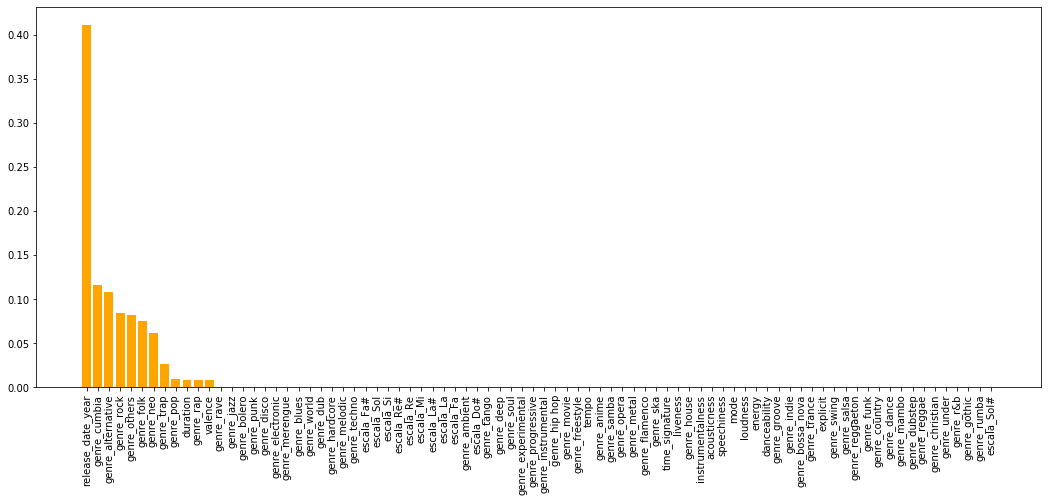

In [244]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(tree_importancia_atributos['importancia']))], tree_importancia_atributos['importancia'],color='orange', linewidth=0.8)
plt.xticks(range(0,len(tree_importancia_atributos['Atributo'])), tree_importancia_atributos['Atributo'], rotation=90)
plt.show()

##### Predictions

In [245]:
classifier_tree_y_pred = tree.predict(X_test_simplified_smoted_scaled)

##### Analizamos los resultados en la matriz de confusión

array([1817,  836,  161,  475, 1883,  515,   55,  782, 2045], dtype=int64)

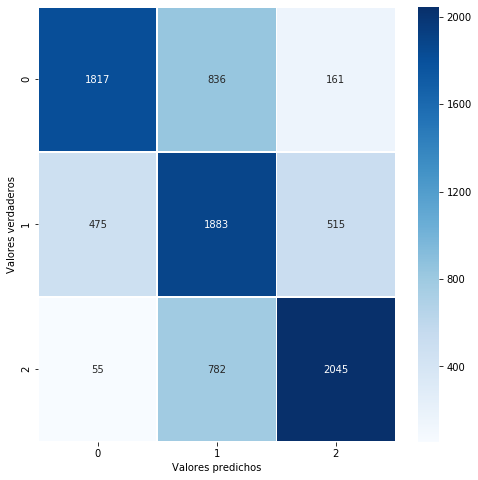

In [246]:
funcs.getConfusionMatrix(y_test_simplified_smoted, classifier_tree_y_pred, size= 8, labels= classes_labels)

## Random Forest <a id="model_random_forest"></a>

<a href="#titulo">Volver al índice</a>

##### Creamos el pipe

In [247]:
random_forest_pasos = [('preprocesamiento', MinMaxScaler()), 
                 ('clasificador', RandomForestClassifier(class_weight='balanced', random_state=42))]

random_forest_pipe_grid=Pipeline(random_forest_pasos)

##### Definimos hiperparámetros para el modelo

In [248]:
random_forest_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],                       
                       'clasificador__n_estimators':[50, 100, 200],                       
                       'clasificador__max_depth':[3,6,9], 
                       #'clasificador__max_features':[70,75,82],
                       'clasificador__max_leaf_nodes':[10,15,20],
                       'clasificador__min_samples_leaf':range(1, 4),
                      'clasificador__min_samples_split': [9, 12, 15]
                      }]


In [249]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    random_forest_grid=GridSearchCV(random_forest_pipe_grid, random_forest_param_grid, cv=kf, n_jobs=-1, verbose=2)
    random_forest_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [250]:
if(not leer_modelos_desde_pickle):
    pickle.dump(random_forest_grid, open('random_forest_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [251]:
if(leer_modelos_desde_pickle):
    random_forest_grid = pickle.load(open('random_forest_grid.pkl', 'rb'))

In [252]:
print('Mejor estimador GridCV: ' + str(random_forest_grid.best_estimator_))
print('Mejor score GridCV: ' + str(random_forest_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('clasificador',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        max_leaf_nodes=20, min_samples_split=12,
                                        n_estimators=200, random_state=42))])
Mejor score GridCV: 0.7017606892719579


In [253]:
random_forest_grid.best_params_

{'clasificador__max_depth': 9,
 'clasificador__max_leaf_nodes': 20,
 'clasificador__min_samples_leaf': 1,
 'clasificador__min_samples_split': 12,
 'clasificador__n_estimators': 200,
 'preprocesamiento': StandardScaler()}

In [254]:
#aplicamos el scaler sobre los datos de train y test
X_train_simplified_smoted_scaled = random_forest_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = random_forest_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

#instanciamos nuevamente un decision tree classifier con los mejores parámetros obtenidos
random_forest = RandomForestClassifier(
                            random_state= 42,
                            n_estimators=random_forest_grid.best_params_['clasificador__n_estimators'],
                             max_depth=random_forest_grid.best_params_['clasificador__max_depth'],
                             max_leaf_nodes= random_forest_grid.best_params_['clasificador__max_leaf_nodes'],
                             min_samples_leaf= random_forest_grid.best_params_['clasificador__min_samples_leaf'],
                             min_samples_split= random_forest_grid.best_params_['clasificador__min_samples_split'])
#fiteamos
random_forest.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)

RandomForestClassifier(max_depth=9, max_leaf_nodes=20, min_samples_split=12,
                       n_estimators=200, random_state=42)

In [255]:
random_forest_score_training = random_forest.score(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
print('Random forest training score: ' + str(random_forest_score_training))

Random forest training score: 0.7044113233970191


In [256]:
random_forest_score_test = random_forest.score(X_test_simplified_smoted_scaled, y_test_simplified_smoted)
print('Random forest tree training score: ' + str(random_forest_score_test))

Random forest tree training score: 0.6957637997432606


In [257]:
guardar_resultados('Random Forest', random_forest_score_training, random_forest_score_test)

##### Predictions

In [258]:
random_forest_y_pred = random_forest.predict(X_test_simplified_smoted_scaled)

##### Analizamos los resultados en la matriz de confusión

array([2050,  569,  195,  659, 1526,  688,   91,  405, 2386], dtype=int64)

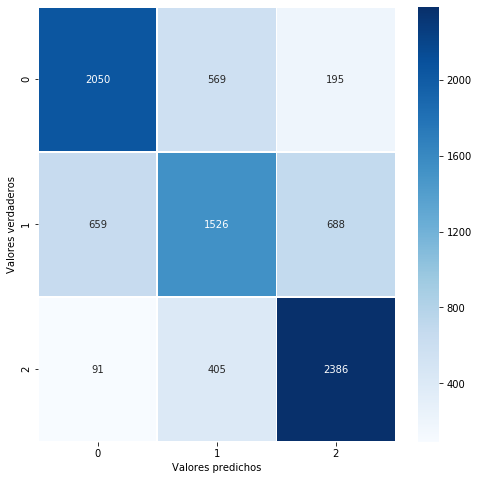

In [259]:
funcs.getConfusionMatrix(y_test_simplified_smoted, random_forest_y_pred, size= 8, labels= classes_labels)

## Extra Tree Classifier<a id="model_extra_tree"></a>

<a href="#titulo">Volver al índice</a>

##### Creamos el pipe

In [260]:
extra_tree_pasos = [('preprocesamiento', MinMaxScaler()), 
                 ('clasificador', ExtraTreesClassifier(class_weight='balanced', random_state=42))]

random_forest_pipe_grid=Pipeline(random_forest_pasos)

##### Definimos hiperparámetros para el modelo

In [261]:
extra_tree_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],                       
                       'clasificador__n_estimators':[50, 100, 200],
                       'clasificador__max_depth':[20, 25, 30],                        
                       'clasificador__max_leaf_nodes':[130, 140, 150],
                       'clasificador__min_samples_leaf':[2,3,4],
                      'clasificador__min_samples_split': [9, 12, 15]
                      }]


In [262]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    extra_tree_grid=GridSearchCV(random_forest_pipe_grid, extra_tree_param_grid, cv=kf, n_jobs=-1, verbose=2)
    extra_tree_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [263]:
if(not leer_modelos_desde_pickle):
    pickle.dump(extra_tree_grid, open('extra_tree_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [264]:
if(leer_modelos_desde_pickle):
    extra_tree_grid = pickle.load(open('extra_tree_grid.pkl', 'rb'))

In [265]:
print('Mejor estimador GridCV: ' + str(extra_tree_grid.best_estimator_))
print('Mejor score GridCV: ' + str(extra_tree_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('clasificador',
                 RandomForestClassifier(class_weight='balanced', max_depth=25,
                                        max_leaf_nodes=150, min_samples_leaf=2,
                                        min_samples_split=9, n_estimators=200,
                                        random_state=42))])
Mejor score GridCV: 0.7335131043618128


In [266]:
extra_tree_grid.best_params_

{'clasificador__max_depth': 25,
 'clasificador__max_leaf_nodes': 150,
 'clasificador__min_samples_leaf': 2,
 'clasificador__min_samples_split': 9,
 'clasificador__n_estimators': 200,
 'preprocesamiento': StandardScaler()}

In [267]:
#aplicamos el scaler sobre los datos de train y test
X_train_simplified_smoted_scaled = extra_tree_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = extra_tree_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

#instanciamos nuevamente un decision tree classifier con los mejores parámetros obtenidos
extra_tree = ExtraTreesClassifier(
                            random_state= 42,
                            n_estimators=extra_tree_grid.best_params_['clasificador__n_estimators'],
                             max_depth=extra_tree_grid.best_params_['clasificador__max_depth'],
                             max_leaf_nodes= extra_tree_grid.best_params_['clasificador__max_leaf_nodes'],
                             min_samples_leaf= extra_tree_grid.best_params_['clasificador__min_samples_leaf'],
                             min_samples_split= extra_tree_grid.best_params_['clasificador__min_samples_split'])
#fiteamos
extra_tree.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)

ExtraTreesClassifier(max_depth=25, max_leaf_nodes=150, min_samples_leaf=2,
                     min_samples_split=9, n_estimators=200, random_state=42)

In [268]:
extra_tree_score_training = extra_tree.score(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
print('Random forest training score: ' + str(extra_tree_score_training))

Random forest training score: 0.7615784735420627


In [269]:
extra_tree_score_test = extra_tree.score(X_test_simplified_smoted_scaled, y_test_simplified_smoted)
print('Random forest tree training score: ' + str(extra_tree_score_test))

Random forest tree training score: 0.7341580114365737


In [270]:
guardar_resultados('Extra Trees Classifier', extra_tree_score_training, extra_tree_score_test)

##### Predictions

In [271]:
extra_tree_y_pred = extra_tree.predict(X_test_simplified_smoted_scaled)

##### Analizamos los resultados en la matriz de confusión

array([2095,  594,  125,  583, 1842,  448,   87,  441, 2354], dtype=int64)

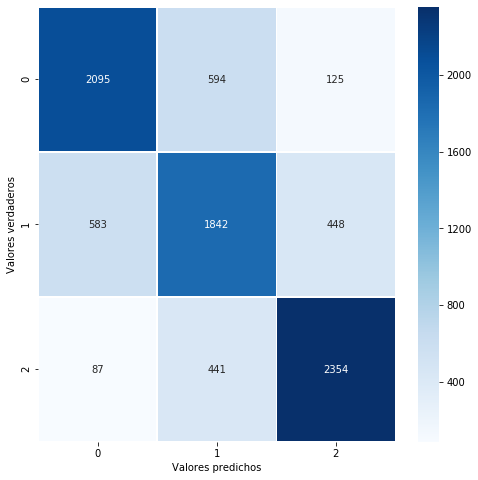

In [272]:
funcs.getConfusionMatrix(y_test_simplified_smoted, extra_tree_y_pred, size= 8, labels= classes_labels)

## Bagging con Decision Tree<a id="model_bagging_decision_tree"></a>

<a href="#titulo">Volver al índice</a>

##### Creamos el pipe

In [273]:
#usamos el mejor Decision Tree Classifier obtenido en el grid search CV
bagging_pasos = [('preprocesamiento', MinMaxScaler()), 
                 ('clasificador', BaggingClassifier(tree, random_state=42))]

bagging_pipe_grid=Pipeline(bagging_pasos)

##### Definimos hiperparámetros para el modelo

In [274]:
bagging_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],                       
                       'clasificador__n_estimators':[50, 100, 200],
                       #usamos como base estimators los mejores obtenidos para decision tree, random forest y extra_tree
                       'clasificador__base_estimator':[tree, random_forest, extra_tree ],                       
                      }]


In [275]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    bagging_grid=GridSearchCV(bagging_pipe_grid, bagging_param_grid, cv=kf, n_jobs=-1, verbose=2)
    bagging_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [276]:
if(not leer_modelos_desde_pickle):
    pickle.dump(bagging_grid, open('bagging_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [277]:
if(leer_modelos_desde_pickle):
    bagging_grid = pickle.load(open('bagging_grid.pkl', 'rb'))

In [278]:
print('Mejor estimador GridCV: ' + str(bagging_grid.best_estimator_))
print('Mejor score GridCV: ' + str(bagging_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                ('clasificador',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=25,
                                                                         max_features=82,
                                                                         max_leaf_nodes=150,
                                                                         min_samples_split=9,
                                                                         random_state=42),
                                   n_estimators=100, random_state=42))])
Mejor score GridCV: 0.73516889015044


In [279]:
#aplicamos el scaler sobre los datos de train y test
X_train_simplified_smoted_scaled = bagging_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = bagging_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)


In [280]:
bagging_score_training = bagging_grid.score(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
print('Bagging training score: ' + str(bagging_score_training))

Bagging training score: 0.6338401520456137


In [281]:
bagging_score_test = bagging_grid.score(X_test_simplified_smoted_scaled, y_test_simplified_smoted)
print('Bagging tree training score: ' + str(bagging_score_test))

Bagging tree training score: 0.6168747811880033


In [282]:
guardar_resultados('Bagging', bagging_score_training, bagging_score_test)

##### Predictions

In [283]:
bagging_y_pred = bagging_grid.predict(X_test_simplified_smoted_scaled)

##### Analizamos los resultados en la matriz de confusión

array([2371,  430,   13, 1169, 1650,   54,  511, 1106, 1265], dtype=int64)

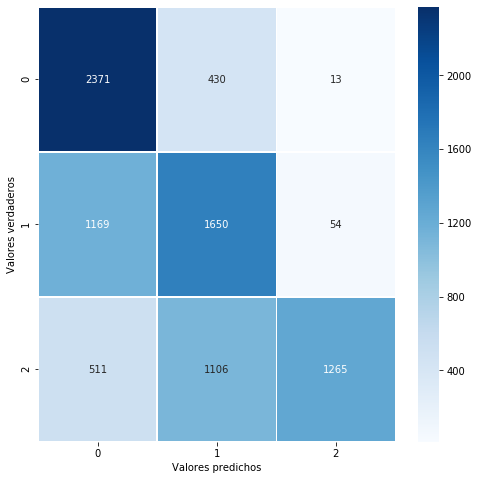

In [284]:
funcs.getConfusionMatrix(y_test_simplified_smoted, bagging_y_pred, size= 8, labels= classes_labels)

# Feature Selection <a id="feature_selection"></a>

## Logistic Regression <a id="feature_selection_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [285]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
estimator = linear_model.LogisticRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)

##### Definimos un grid search, para optimizar el feature selector con el hiperparámetro C de la regresión logística obtenido para todo el DF

In [286]:
X_train_simplified_smoted_scaled = reg_log_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = reg_log_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

grid_hiperparametros = {'estimator__random_state': [reg_log_grid.best_params_['clasificador__random_state']], 
                        'estimator__C':[reg_log_grid.best_params_['clasificador__C']], 
                        'estimator__penalty':[reg_log_grid.best_params_['clasificador__penalty']],
                        'estimator__multi_class':[reg_log_grid.best_params_['clasificador__multi_class']],
                        'estimator__class_weight':[reg_log_grid.best_params_['clasificador__class_weight']],
                        'estimator__solver': [reg_log_grid.best_params_['clasificador__solver']]                       
                       }

In [287]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    reg_log_fs_grid = RandomizedSearchCV(estimator=selector, param_distributions=grid_hiperparametros, cv=kf, random_state = 42,n_jobs=-1,verbose=2)
    reg_log_fs_grid.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [288]:
if(not leer_modelos_desde_pickle):
    pickle.dump(reg_log_fs_grid, open('reg_log_fs_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [289]:
if(leer_modelos_desde_pickle):
    reg_log_fs_grid = pickle.load(open('reg_log_fs_grid.pkl', 'rb'))

### Analizamos cómo resultó el feature selection

In [290]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % reg_log_fs_grid.best_estimator_.n_features_)

Número original de features : 82
Número óptimo de features : 78


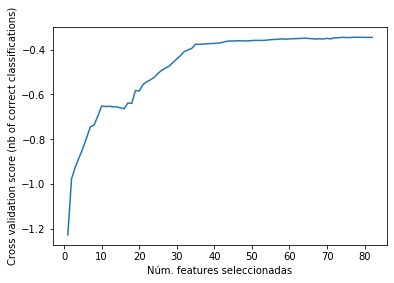

In [291]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(reg_log_fs_grid.best_estimator_.grid_scores_) + 1), reg_log_fs_grid.best_estimator_.grid_scores_)
plt.show()

In [292]:
reg_log_FS_score_training = reg_log_fs_grid.best_score_
print('Regresión Logística FS train score: ' + str(reg_log_FS_score_training))

Regresión Logística FS train score: 0.7344116269268671


In [293]:
X_test_FS = reg_log_grid.best_params_['preprocesamiento'].fit_transform(X_test_simplified_smoted)
reg_log_FS_score_test = reg_log_fs_grid.score(X_test_FS, y_test_simplified_smoted)
print('Regresión Logística FS trainig score: ' + str(reg_log_FS_score_test))

Regresión Logística FS trainig score: 0.7353250087524799


In [294]:
guardar_resultados('Logistic Regresion Feature Selection', reg_log_FS_score_training, reg_log_FS_score_test)

##### Predictions

In [295]:
FS_reg_log_predicciones = reg_log_fs_grid.predict(X_test_FS)

array([2082,  606,  126,  610, 1891,  372,   67,  487, 2328], dtype=int64)

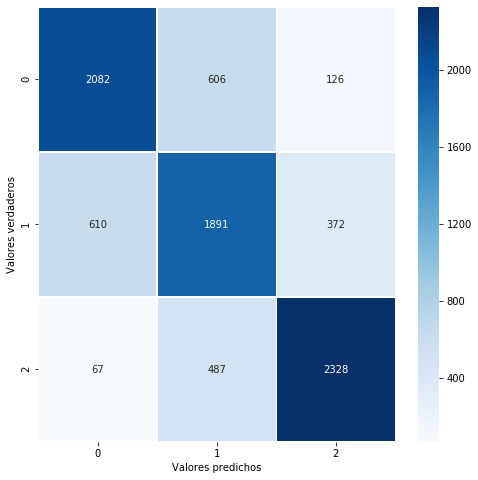

In [296]:
funcs.getConfusionMatrix(y_test_simplified_smoted, FS_reg_log_predicciones, size = 8, labels= classes_labels)

##### Aporte de cada uno de los coeficientes

In [297]:
lr_coeficientes = reg_log_fs_grid.best_estimator_.estimator_.coef_

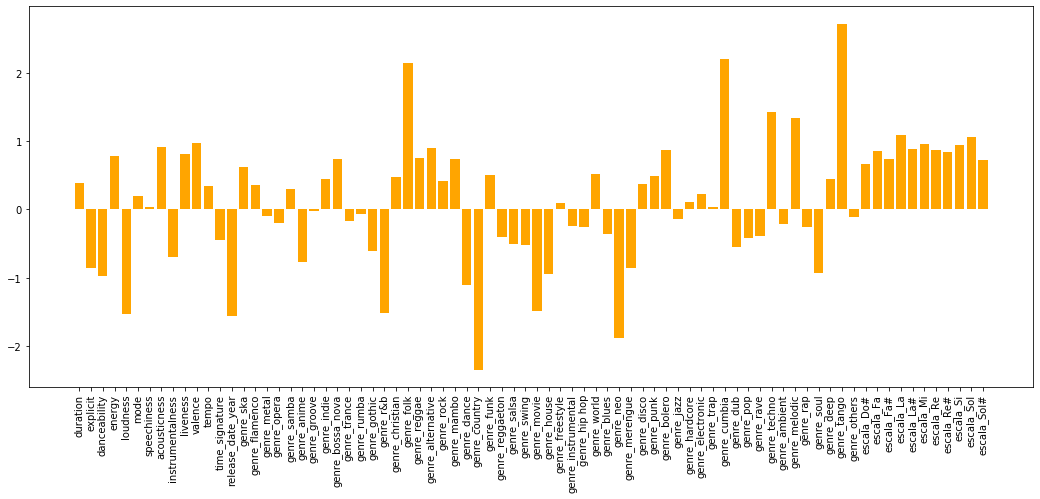

In [298]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_train_simplified_smoted[X_train_simplified_smoted.columns[reg_log_fs_grid.best_estimator_.support_]].columns, rotation=90)
plt.show()

## Multinomial Naive Bayes  <a id="feature_selection_bernoulli_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [299]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
estimator = MultinomialNB()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)

##### Definimos un grid search, para optimizar el feature selector con el hiperparámetro C de la regresión logística obtenido para todo el DF

In [300]:
X_train_simplified_smoted_scaled = bnb_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = bnb_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

grid_hiperparametros = {'estimator__alpha': [bnb_grid.best_params_['clasificador__alpha']],                                             
                       }

In [301]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    mnb_fs_grid = RandomizedSearchCV(estimator=selector, param_distributions=grid_hiperparametros, cv=kf, random_state = 42,n_jobs=-1,verbose=2)
    mnb_fs_grid.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [302]:
if(not leer_modelos_desde_pickle):
    pickle.dump(mnb_fs_grid, open('mnb_fs_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [303]:
if(leer_modelos_desde_pickle):
    mnb_fs_grid = pickle.load(open('mnb_fs_grid.pkl', 'rb'))

### Analizamos cómo resultó el feature selection

In [304]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % mnb_fs_grid.best_estimator_.n_features_)

Número original de features : 82
Número óptimo de features : 82


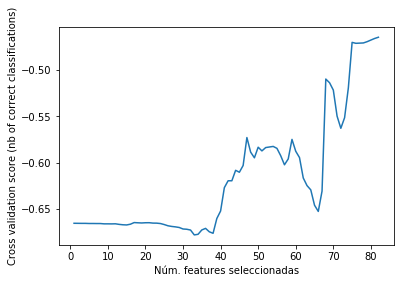

In [305]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(mnb_fs_grid.best_estimator_.grid_scores_) + 1), mnb_fs_grid.best_estimator_.grid_scores_)
plt.show()

##### Vemos los resultados

In [306]:
bnb_FS_score_training = mnb_fs_grid.best_score_
print('Multinomial Naive Bayes FS training score: ' + str(bnb_FS_score_training))

Multinomial Naive Bayes FS training score: 0.6872455398339146


In [307]:
X_test_FS = bnb_grid.best_params_['preprocesamiento'].fit_transform(X_test_simplified_smoted)
bnb_FS_score_test = mnb_fs_grid.score(X_test_FS, y_test_simplified_smoted)
print('Multinomial Naive Bayes FS test score: ' + str(bnb_FS_score_test))

Multinomial Naive Bayes FS test score: 0.691679309137589


In [308]:
guardar_resultados('Multinomial Naive Bayes Feature Selection', bnb_FS_score_training, bnb_FS_score_test)

##### Predictions

In [309]:
FS_bnb_predicciones = mnb_fs_grid.predict(X_test_FS)

array([2087,  432,  295,  717, 1392,  764,  135,  299, 2448], dtype=int64)

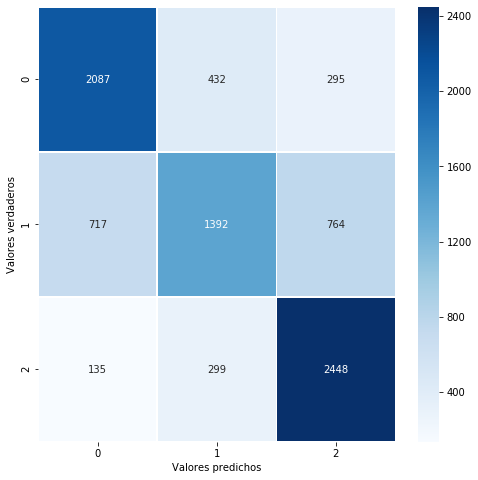

In [310]:
funcs.getConfusionMatrix(y_test_simplified_smoted, FS_bnb_predicciones, size = 8, labels= classes_labels)

# Resultados <a id="results"></a>

<a href="#titulo">Volver al índice</a>

In [311]:
#Resultados de todos los modelos, ordenados por el score de testing descendente
df_resultados = pd.DataFrame(array_resultados)
df_resultados.sort_values('test_score', ascending=False)

,modelo,train_score,test_score
2,KNN,0.875863,0.875015
0,Logistic Regression,0.745124,0.737076
7,Logistic Regresion Feature Selection,0.734412,0.735325
5,Extra Trees Classifier,0.761578,0.734158
4,Random Forest,0.704411,0.695764
8,Multinomial Naive Bayes Feature Selection,0.687246,0.691679
1,Multinomial Naive Bayes,0.696409,0.691446
3,Decision Tree Classifier,0.680104,0.670440
6,Bagging,0.633840,0.616875


In [312]:
print('SIN FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_test_simplified_smoted,reg_log_predicciones))
print('-----------------------------------------------------------')
print('Multinomial Naive Bayes')
print(classification_report(y_test_simplified_smoted,bnb_predicciones))
print('-----------------------------------------------------------')
print('KNN')
print(classification_report(y_test_simplified_smoted,knn_y_pred))
print('-----------------------------------------------------------')
print('Decision Tree Classifier')
print(classification_report(y_test_simplified_smoted,classifier_tree_y_pred))
print('-----------------------------------------------------------')
print('Random Forest')
print(classification_report(y_test_simplified_smoted,random_forest_y_pred))
print('-----------------------------------------------------------')
print('Extra Trees')
print(classification_report(y_test_simplified_smoted,extra_tree_y_pred))
print('-----------------------------------------------------------')
print('Bagging')
print(classification_report(y_test_simplified_smoted,bagging_y_pred))

SIN FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2814
           1       0.65      0.63      0.64      2873
           2       0.81      0.83      0.82      2882

    accuracy                           0.74      8569
   macro avg       0.74      0.74      0.74      8569
weighted avg       0.74      0.74      0.74      8569

-----------------------------------------------------------
Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      2814
           1       0.66      0.48      0.56      2873
           2       0.70      0.85      0.77      2882

    accuracy                           0.69      8569
   macro avg       0.69      0.69      0.68      8569
weighted avg       0.69      0.69      0.68      8569

--------------------------------------------------

In [313]:
print('CON FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_test_simplified_smoted,FS_reg_log_predicciones))
print('-----------------------------------------------------------')
print('Multinomial Naive Bayes')
print(classification_report(y_test_simplified_smoted,FS_bnb_predicciones))
print('-----------------------------------------------------------')

CON FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      2814
           1       0.63      0.66      0.65      2873
           2       0.82      0.81      0.82      2882

    accuracy                           0.74      8569
   macro avg       0.74      0.74      0.74      8569
weighted avg       0.74      0.74      0.74      8569

-----------------------------------------------------------
Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      2814
           1       0.66      0.48      0.56      2873
           2       0.70      0.85      0.77      2882

    accuracy                           0.69      8569
   macro avg       0.69      0.69      0.68      8569
weighted avg       0.69      0.69      0.68      8569

--------------------------------------------------

# Prediciendo en el set de test 2020 <a id="test_analysis"></a>

<a href="#titulo">Volver al índice</a>

##### Levantamos el csv de test

In [314]:
pathArchivoDataSetTest = 'tracks_clean_test.csv' 
df_test = pd.read_csv(pathArchivoDataSetTest)

In [315]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          450 non-null    int64  
 1   name                450 non-null    object 
 2   album               450 non-null    object 
 3   duration_ms         450 non-null    int64  
 4   explicit            450 non-null    int64  
 5   danceability        450 non-null    float64
 6   energy              450 non-null    float64
 7   loudness            450 non-null    float64
 8   mode                450 non-null    int64  
 9   speechiness         450 non-null    float64
 10  acousticness        450 non-null    float64
 11  instrumentalness    450 non-null    float64
 12  liveness            450 non-null    float64
 13  valence             450 non-null    float64
 14  tempo               450 non-null    float64
 15  artista_followers   450 non-null    int64  
 16  artista_

##### Aplicamos los mismos cambios en la variables que en el entrenamiento

##### Eliminamos repetidos por nombre de tema y nombre de artista, nos quedamos con el último

In [316]:
df_test = df_test.drop_duplicates(subset=['name','artista_name'],keep='last')

##### Codificamos la fecha de release_date a integer

In [317]:
df_test['release_date_year'] = df_test['release_date'].apply(lambda f: f[0:4])

In [318]:
#solo tiene datos del año actual
df_test['release_date_year'].unique()

array(['2020'], dtype=object)

#### Generación de dummies para el dato 'escala'

In [319]:
df_test = pd.get_dummies(df_test, drop_first=True, columns=['escala'])

##### Transformamos la variable duration_ms en duration, que es en minutos

In [320]:
df_test['duration'] = df_test['duration_ms'] / 1000 / 60

In [321]:
#quitamos la duracion en ms
df_test = df_test.drop(labels=['duration_ms'], axis=1)

##### Usamos nuestro mejor modelo, KNN

In [322]:
knn_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                                       ('clasificador',
                                        KNeighborsClassifier(n_neighbors=2))]),
             param_grid=[{'clasificador__algorithm': ['ball_tree', 'kd_tree'],
                          'clasificador__leaf_size': [range(10, 60, 5)],
                          'clasificador__n_neighbors': range(1, 4),
                          'clasificador__weights': ['uniform', 'distance'],
                          'preprocesamiento': [MinMaxScaler(),
                                               StandardScaler()]},
                         {'clasificador__algorithm': ['brute'],
                          'clasificador__n_neighbors': range(1, 4),
                          'clasificador__weights': ['uniform', 'distance'],
                          'preprocesamiento': [MinMaxScaler(),
              

##### Tomamos las features input para la predicción

In [323]:
df_prediccion = df_test[training_cols]

##### Aplicamos el escaler

In [324]:
x_resultados_test = knn_grid.best_params_['preprocesamiento'].fit_transform(df_prediccion)

In [325]:
y_resultados_pred = knn_grid.predict(x_resultados_test)

In [326]:
zipped = zip( df_prediccion.index, y_resultados_pred)
listado = list(zipped)

In [327]:
print("Clases posibles: " + str(target_classes_labels))

Clases posibles: {0: 'mala', 1: 'buena', 2: 'muy_buena'}


In [328]:
best_tracks_ids = []

for x in listado:
    if(x[1] == 2):
        best_tracks_ids.append(x[0])


In [329]:
best_tracks_ids

[0, 228, 230, 272, 299, 300, 400, 401, 434]

In [330]:
df_test[df_test.index.isin(best_tracks_ids)][['name', 'artista_name', 'popularity']]

,name,artista_name,popularity
0,La Jeepeta - Remix,Nio Garcia,88
228,Verde,J Balvin,77
230,Bésame (I Need You) (with TINI & Reik),R3HAB,72
272,25/8,Bad Bunny,78
299,Blueberry Faygo,Lil Mosey,88
300,No Se,Ke Personajes,55
400,Break My Heart - Moon Boots Remix,Dua Lipa,36
401,Break My Heart,Dua Lipa,35
434,Dance Monkeyx,Fer Palacio,53


Los índices de popularidad de los tracks corresponden a la fecha en que fue creado el CSV. Aquellos tracks con popularidad alta, y que fueron elegidos, sirven como confirmación de que las otras features lo identificaron como un éxito (ej. el track "La Jeepeta - Remix" de Nio Garcia).
Los que tenían baja popularidad al momento de generar el CSV, pero fueron seleccionados con la clase 2 (muy_buena), de acuerdo al modelo, deberían tener un aumento en el índice de popularity para condecirse con las predicciones del modelo.